In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

In [52]:
df

,_timestamp,valid_count,clip_correct,clip_similarity_overall,overall,_runtime,_wandb,detail,visual,textual,...,task_id,x_space,data_mode,file_type,finetuned,task_type,prompt_type,theta_space,run_name,run_id
0,1.711579e+09,250,0.076,25.662605,0.08,132.731873,{'runtime': 132},0.264,0.264,0.544,...,10,object,ft_test,image,0,texture_object,default,texture,helpful-armadillo-1323,nyl44rcz
1,1.711579e+09,250,0.128,27.572796,0.108,136.718668,{'runtime': 136},0.256,0.664,0.256,...,9,texture,ft_test,image,0,texture_object,default,object,stellar-capybara-1322,b44z4vzp
2,1.711578e+09,250,0.252,26.412945,0.196,140.600027,{'runtime': 140},0.416,0.416,0.564,...,8,animal,ft_test,image,0,action_animal,default,action,golden-lake-1321,23htklk7
3,1.711578e+09,250,0.152,23.656743,0.196,129.648739,{'runtime': 129},0.232,0.652,0.232,...,7,action,ft_test,image,0,action_animal,default,animal,fast-water-1320,totvm0jf
4,1.711578e+09,250,0.272,26.198674,0.164,139.223274,{'runtime': 138},0.332,0.332,0.584,...,6,object,ft_test,image,0,style_object,default,style,lyric-galaxy-1319,d7ya69nr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,1.704498e+09,1000,NaN,NaN,0.571,266.444544,{'runtime': 265},0.732,0.827,0.732,...,5,style,default,text,0,style_object,default,object,dulcet-sea-7,oca9fzwp
1256,1.704498e+09,1000,NaN,NaN,0.364,258.766700,{'runtime': 257},0.376,0.376,0.981,...,4,animal,default,text,0,background_animal,default,background,rare-wildflower-6,dwmc0azq
1257,1.704498e+09,1000,NaN,NaN,0.459,276.669658,{'runtime': 275},0.759,0.626,0.759,...,3,background,default,text,0,background_animal,default,animal,effortless-sea-5,txy4h3x0
1258,1.704497e+09,1000,NaN,NaN,0.568,264.173308,{'runtime': 262},0.722,0.722,0.828,...,2,object,default,text,0,color_object,default,color,still-river-4,ec4ln2nd


# Configuration

In [20]:
def get_acc(
    model, 
    mode, 
    shot, 
    task_id, 
    metric, 
    prompt_type, 
    data_mode,
):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['prompt_type'] == prompt_type) & 
        (df['data_mode'] == data_mode)
    ]
    print(run_df)
    if len(run_df):
        # check whether it is nan or not
        if np.isnan(float(run_df[metric].iloc[0])):
            return 0
        else:
            return float(run_df[metric].item())
    else:
        return 0

In [21]:
get_acc(
    model = 'gpt4v',
    mode = 'text',
    shot = 2,
    task_id = 1,
    metric = 'overall',
    prompt_type = 'default',
    data_mode = 'default',
)

0.844

In [47]:
model_dict = {
    'image': {
        'emu': 'Emu',
        'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
    },
    'text': {
        'emu': 'Emu',
        'emu2': 'Emu2',
        'gill': 'GILL',
        'seed': 'SEED-LLaMA',
        'llava': 'LLaVA-1.5',
        'llava16': 'LLaVA-NeXT',
        'gemini': 'Gemini',
        'qwen': 'Qwen-VL',
        'gpt4v': 'GPT-4V',
    }
}

colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

# Overall Perforamnce Report

In [33]:
def get_shot_bars(
    num_shot,
    task_inference,
    model_mode,
    metric,
    prompt_type,
    data_mode,
):
    task_df = pd.DataFrame(task_dataframe).T
    results = []
    if task_inference == 'object':
        tasks = task_df[(task_df.theta_space == 'object') | (task_df.theta_space == 'animal')]
    else:
        tasks = task_df[(task_df.theta_space != 'object') & (task_df.theta_space != 'animal')]
    for task_id in tasks.index:
        for model_label in model_dict[model_mode]:
            acc = get_acc(
                model = model_label,
                mode = model_mode,
                shot = num_shot,
                task_id = task_id,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            results.append({
                'acc': acc,
                'model': model_label,
                'task_id': task_id,
                'task': task_dataframe[task_id]['task_name']
            })
            
    results_df = pd.DataFrame(results)
    return results_df


In [34]:
get_shot_bars(
    num_shot = 2,
    task_inference ='object',
    model_mode = 'text',
    metric = 'overall',
    prompt_type = 'default',
    data_mode = 'default',
)

,acc,model,task_id,task
0,0.005,emu,1,Color-I
1,0.001,emu2,1,Color-I
2,0.078,gill,1,Color-I
3,0.129,seed,1,Color-I
4,0.865,gemini,1,Color-I
5,0.049,llava,1,Color-I
6,0.031,llava16,1,Color-I
7,0.475,qwen,1,Color-I
8,0.844,gpt4v,1,Color-I
9,0.047,emu,3,Background-I


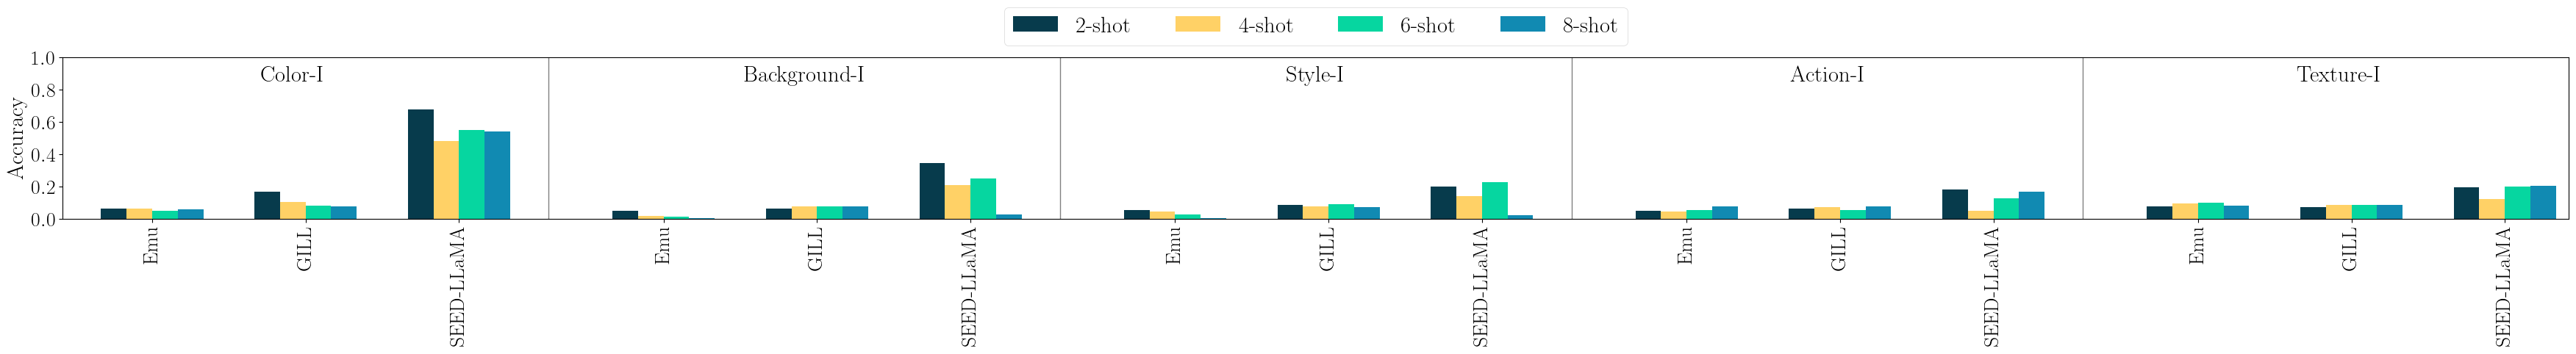

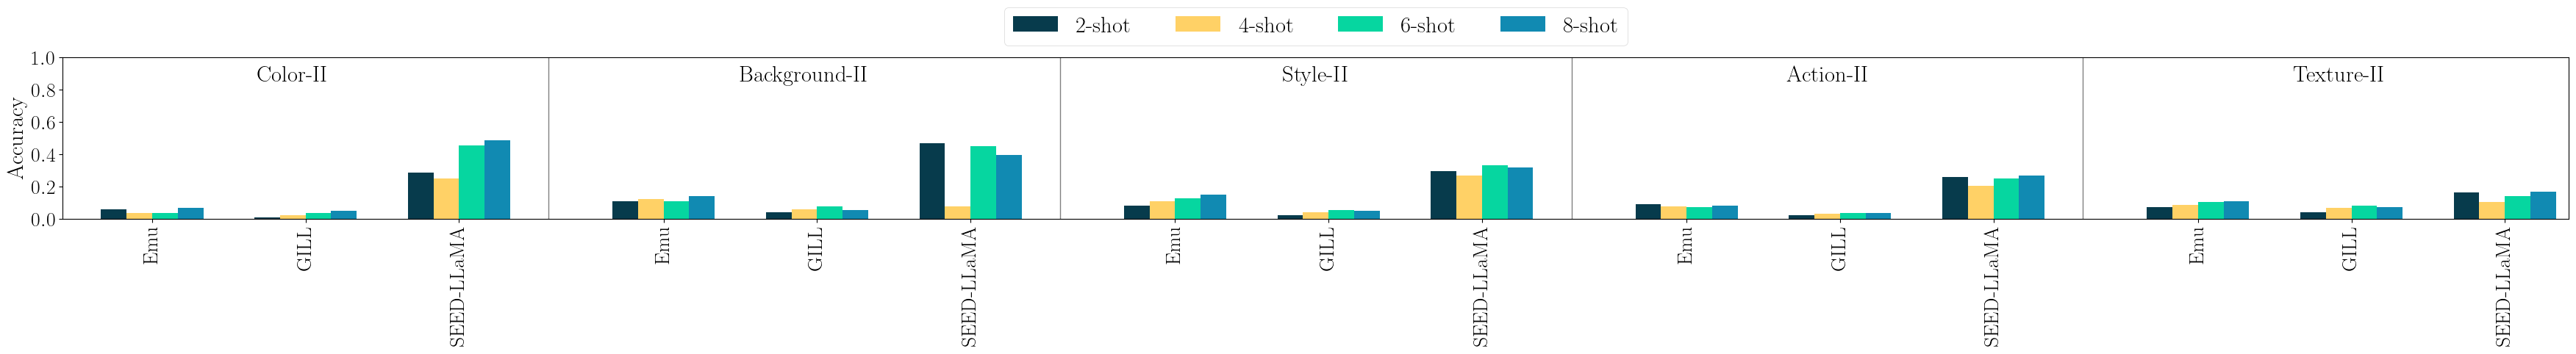

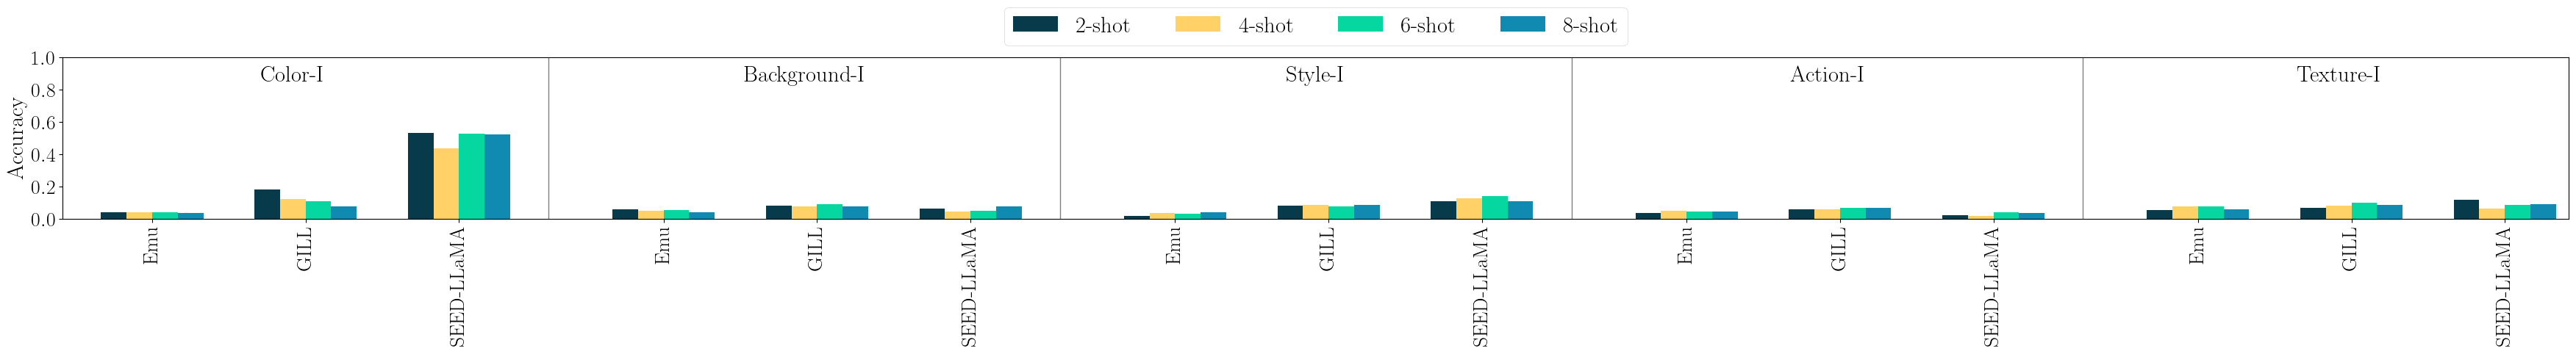

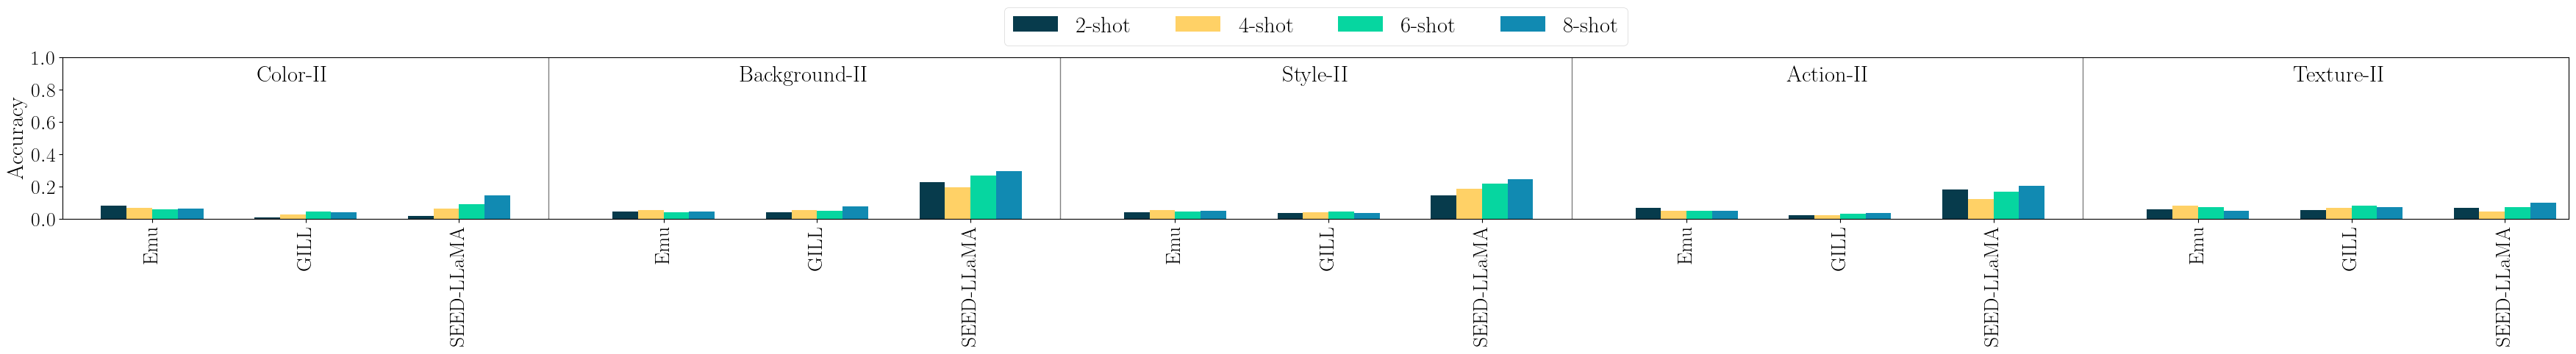

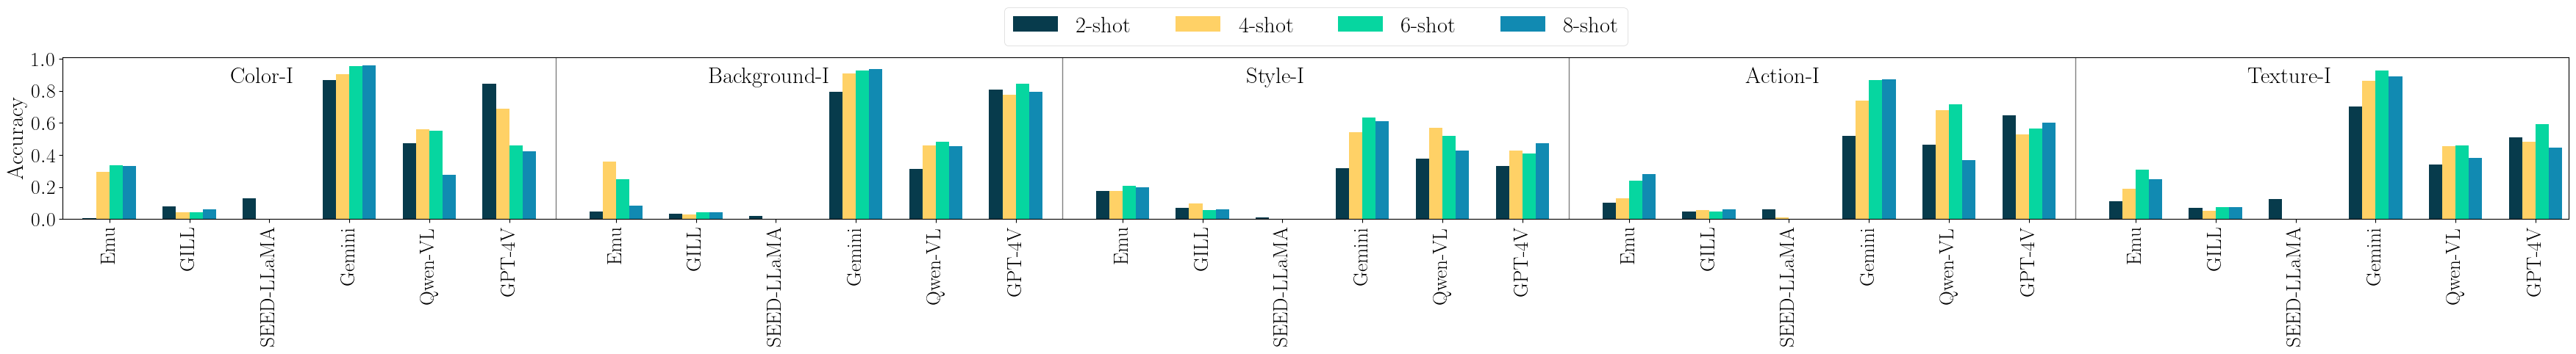

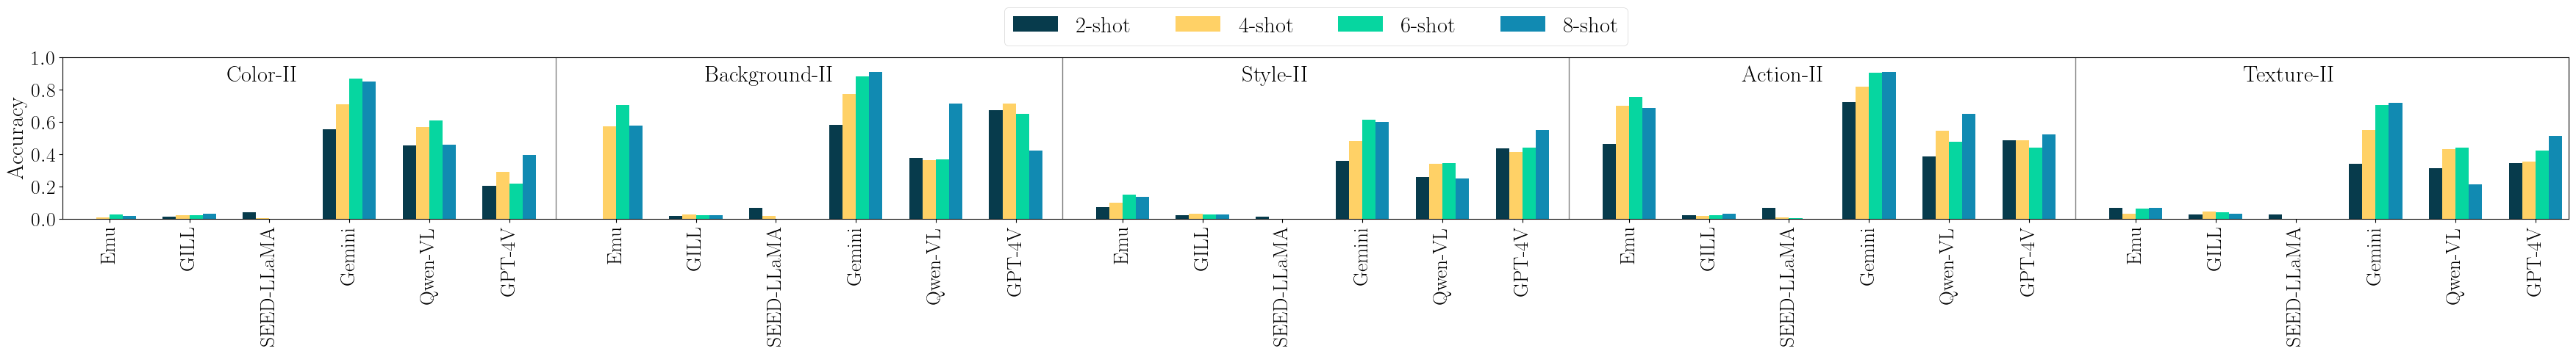

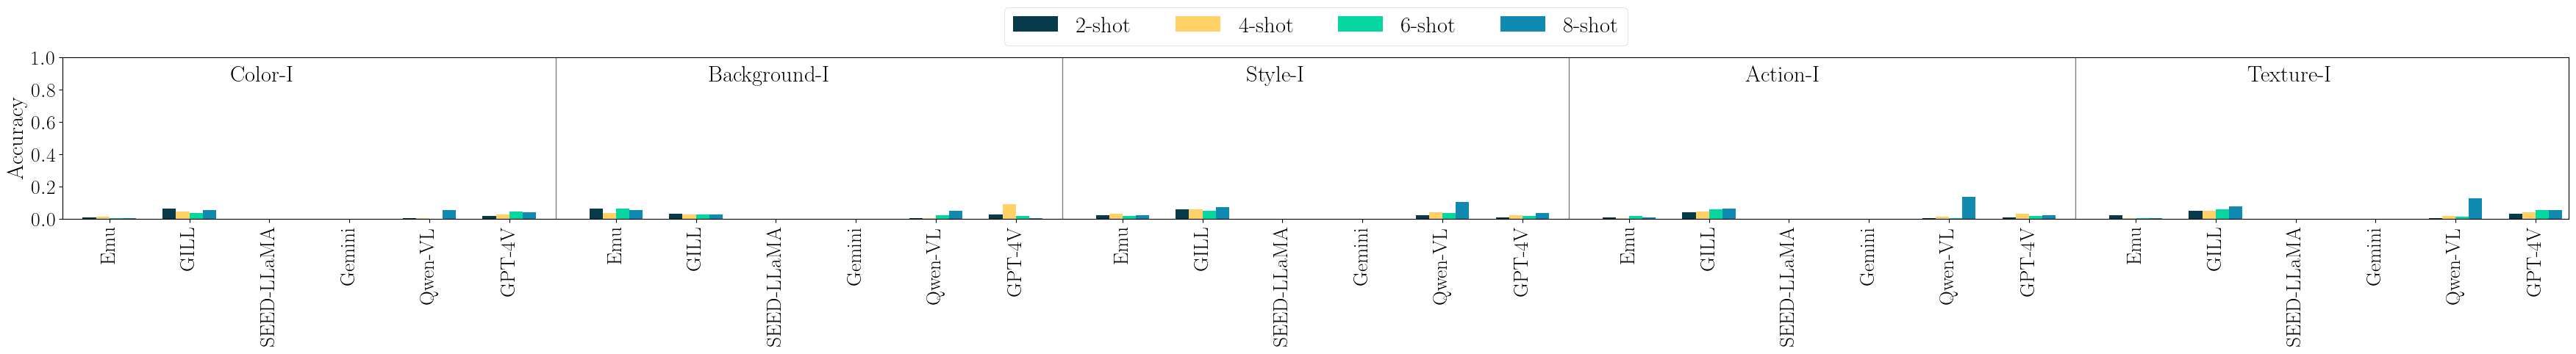

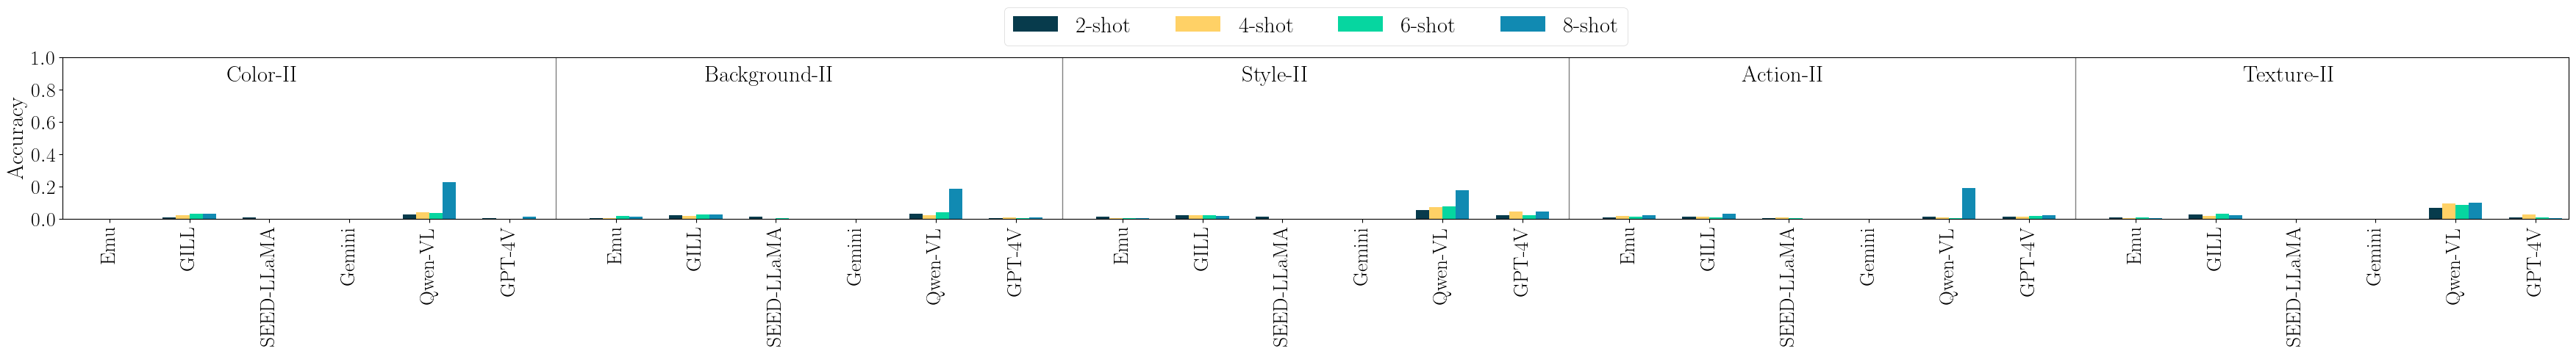

In [40]:
data_mode = 'default'
for model_mode in ['image', 'text']:
    for prompt_type in ['default', 'misleading']:
        for task_inference in ['object', 'detail']:
            bar_width = 2.5
            # ask_inference = task_inference
            # model_mode = model_mode
            width, height = 35, 5
            # prompt_type = prompt_type
            metric = 'overall'
            wspace = 5
            barspace = 15

            r1_data = get_shot_bars(
                num_shot = 2,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


            r2_data = get_shot_bars(
                num_shot = 4,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

            r3_data = get_shot_bars(
                num_shot = 6,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

            r4_data = get_shot_bars(
                num_shot = 8,
                task_inference = task_inference,
                model_mode = model_mode,
                metric = metric,
                prompt_type = prompt_type,
                data_mode = data_mode,
            )
            r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


            fig, ax = plt.subplots(nrows = 1, ncols = 1)
            fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
            fig.set_size_inches(width, height) 

            xticks, xticklabels = [], []
            for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
                ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
                ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
                ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
                ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
                xticks.append((v2['position'] + v3['position'])/2)
                xticklabels.append(model_dict[model_mode][v3['model']])
                
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
                    ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
                    
                if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
                    if not i // len(model_dict[model_mode]) == 4:
                        ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
                
                # add legend
                if i == 0:
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
                    
            ax.set_xticks(xticks)
            ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
            # break the line of the xticklabels
            ax.set_xticklabels(xticklabels, rotation = 90)
            ax.set_yticks(np.arange(0, 1.2, 0.2))
            # set ylabel 
            ax.set_ylabel('Accuracy', fontsize=22)
            save_path = f'{root_dir}/figures/{task_inference}_inference_m_{prompt_type}_{model_mode}.pdf'
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path)
            plt.show()

In [36]:
bar_width = 2.5
task_inference = 'object'
model_mode = 'image'
width, height = 35, 5
prompt_type = 0
metric = 'overall'
wspace = 5
barspace = 15

r1_data = get_shot_bars(
    num_shot = 2,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r1_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])), **r1_data.iloc[i]} for i in range(len(r1_data))]


r2_data = get_shot_bars(
    num_shot = 4,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r2_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + bar_width, **r2_data.iloc[i]} for i in range(len(r2_data))]

r3_data = get_shot_bars(
    num_shot = 6,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r3_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 2 * bar_width, **r3_data.iloc[i]} for i in range(len(r3_data))]

r4_data = get_shot_bars(
    num_shot = 8,
    task_inference = task_inference,
    model_mode = model_mode,
    metric = metric,
    prompt_type = prompt_type,
)
r4_data = [{'position': barspace*i + wspace*(i//len(model_dict[model_mode])) + 3 * bar_width, **r4_data.iloc[i]} for i in range(len(r4_data))]


fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.025, bottom=.41, right=0.999, top=.85, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

xticks, xticklabels = [], []
for i, (v1, v2, v3, v4) in enumerate(zip(r1_data, r2_data, r3_data, r4_data)):
    ax.bar(v1['position'], v1['acc'], width = bar_width, color = colors[0], label = '2-shot')
    ax.bar(v2['position'], v2['acc'], width = bar_width, color = colors[1], label = '4-shot')
    ax.bar(v3['position'], v3['acc'], width = bar_width, color = colors[2], label = '6-shot')
    ax.bar(v4['position'], v4['acc'], width = bar_width, color = colors[3], label = '8-shot')
    xticks.append((v2['position'] + v3['position'])/2)
    xticklabels.append(model_dict[model_mode][v3['model']])
    
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1)//2:
        ax.text(v2['position'], 0.85, v2['task'], fontsize=22, fontweight='bold', ha='center')
        
    if i % len(model_dict[model_mode]) == (len(model_dict[model_mode])-1): 
        if not i // len(model_dict[model_mode]) == 4:
            ax.axvline(x=v4['position'] + wspace, color='grey', linestyle='-', linewidth=1)
    
    # add legend
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), ncol=4, fontsize=22)
        
ax.set_xticks(xticks)
ax.set_xlim(-wspace, wspace + barspace*(len(r1_data)-1) + wspace*(len(r1_data)//len(model_dict[model_mode])))
# break the line of the xticklabels
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_yticks(np.arange(0, 1.2, 0.2))
# set ylabel 
ax.set_ylabel('Accuracy', fontsize=22)
save_path = f'{root_dir}/figures/{task_inference}_inference_m_{prompt_type}_{model_mode}.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path)
plt.show()

TypeError: get_shot_bars() missing 1 required positional argument: 'data_mode'

# Analyze the effect of number of demonstrations

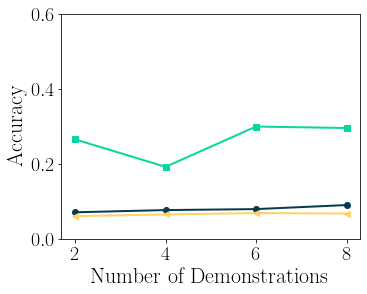

In [12]:
model_mode = 'image'
metric = 'overall'
prompt_type = 0
width, height = 5,4
num_shots = [2,4,6,8]

results = {}
for model in model_dict[model_mode]:
    results[model] = defaultdict(list)
    for shot in num_shots:
        for task_id in task_dataframe:
            results[model][shot].append(get_acc(
                model = model,
                mode = model_mode,
                shot = shot,
                task_id = task_id,
                metric = metric,
                prompt_type = prompt_type,
            ))
        
        results[model][shot] = np.mean(results[model][shot])
results = pd.DataFrame(results)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.subplots_adjust(left=0.16, bottom=.18, right=0.99, top=.96, wspace=0, hspace = 0.3) #margin of the figure
fig.set_size_inches(width, height) 

for i, model in enumerate(results):
    results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
ax.set_xticks(num_shots)
ax.set_xticklabels(num_shots)
ax.set_ylim(0,.6)
ax.set_xlabel('Number of Demonstrations', fontsize=22)
ax.set_ylabel('Accuracy', fontsize=22)
# ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=len(model_dict[model_mode]), fontsize=15)

fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{prompt_type}.pdf')
plt.show()

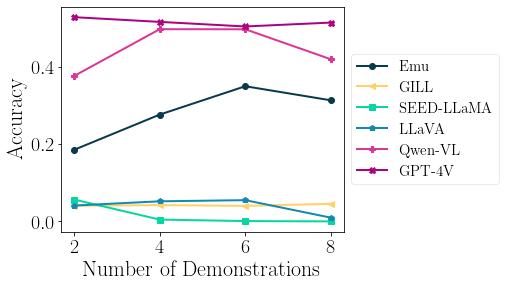

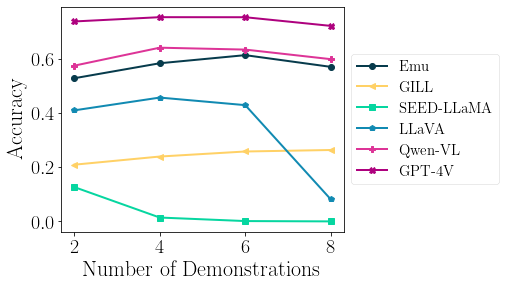

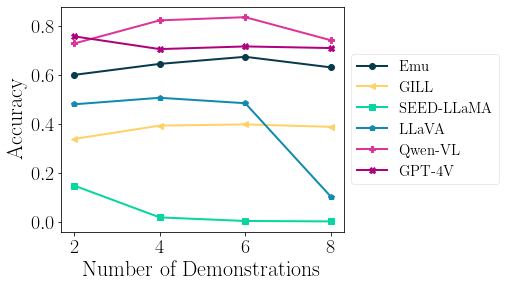

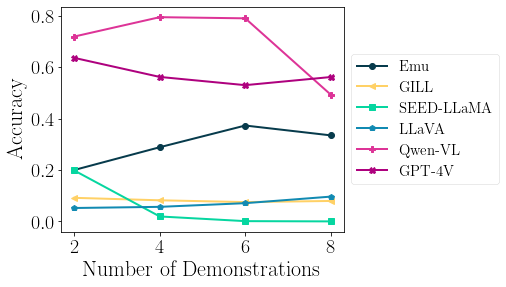

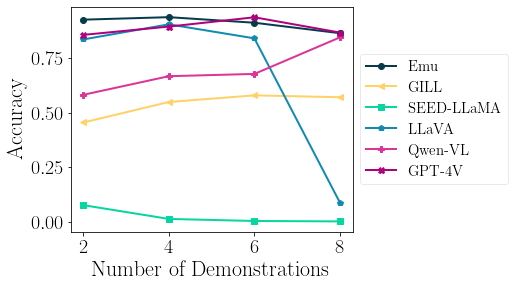

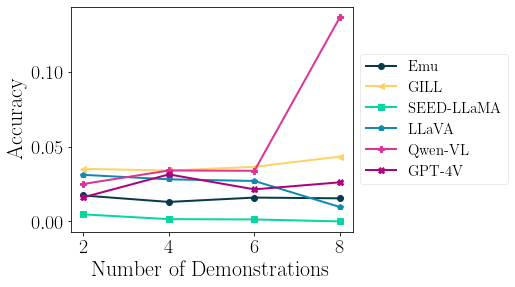

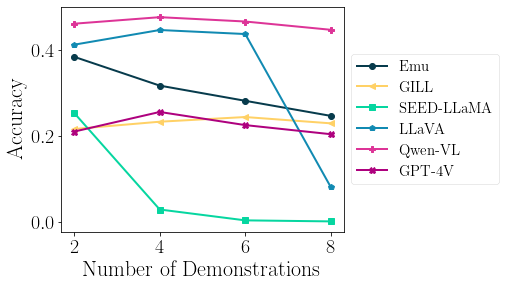

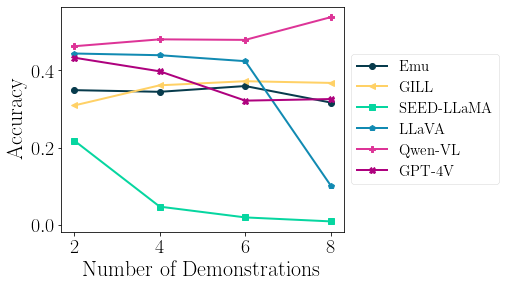

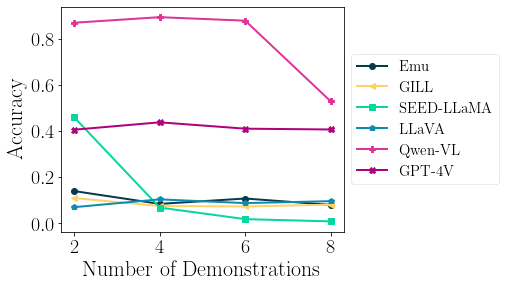

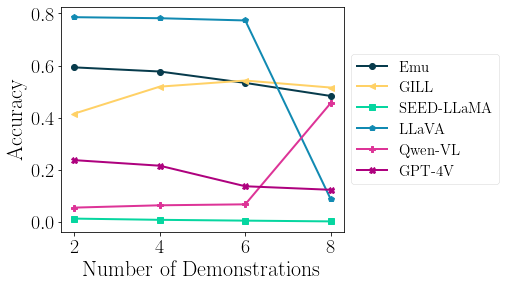

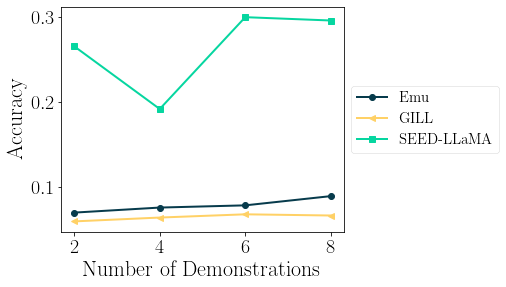

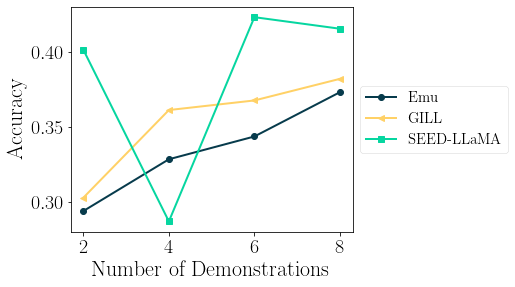

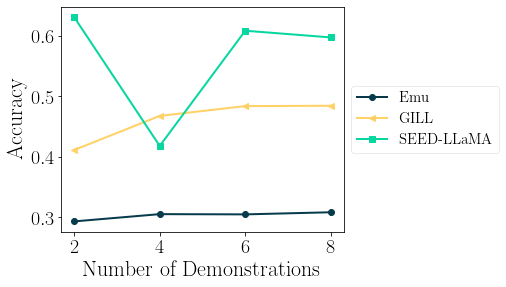

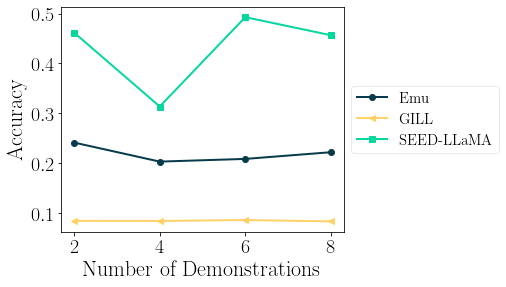

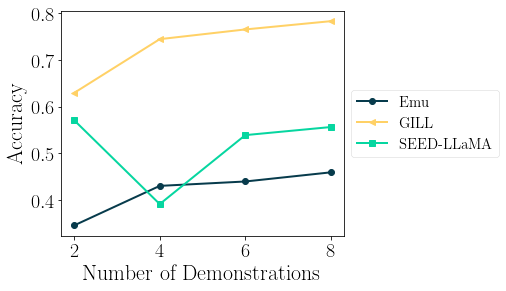

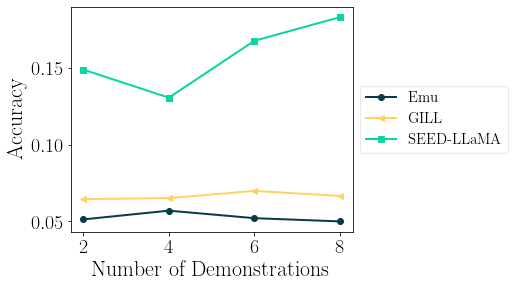

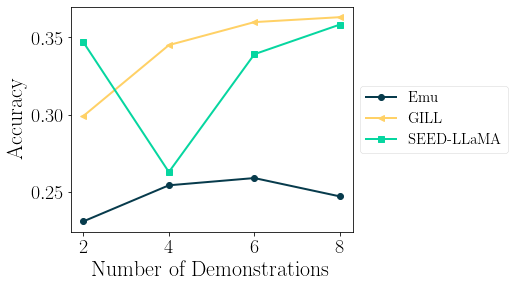

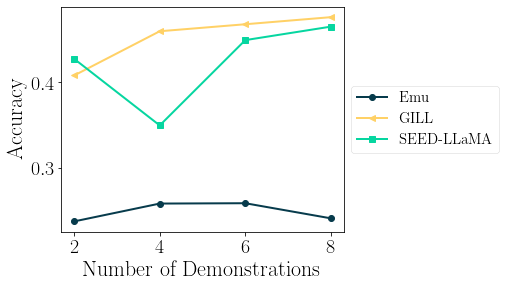

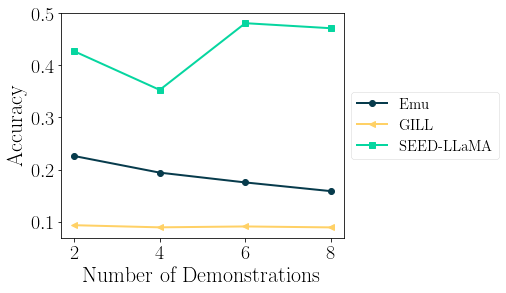

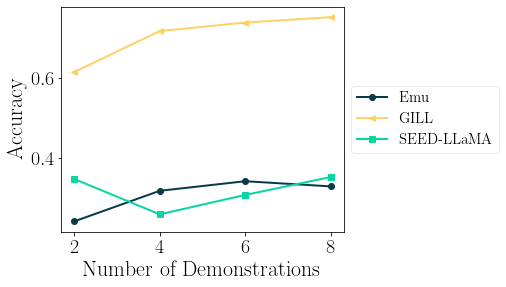

In [13]:
model_mode = 'text'
prompt_type = 0
width, height = 7,4
num_shots = [2,4,6,8]

for model_mode in ['text', 'image']:
    for prompt_type in [0,1]:
        for metric in ['overall', 'detail', 'obj', 'textual', 'visual']:
            results = {}
            for model in model_dict[model_mode]:
                results[model] = defaultdict(list)
                for shot in num_shots:
                    for task_id in task_dataframe:
                        results[model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            prompt_type = prompt_type,
                        ))
                    
                    results[model][shot] = np.mean(results[model][shot])
            results = pd.DataFrame(results)

            fig, ax = plt.subplots(nrows = 1, ncols = 1)
            fig.subplots_adjust(left=0.12, bottom=.18, right=0.68, top=.96, wspace=0, hspace = 0.3) #margin of the figure
            fig.set_size_inches(width, height) 

            for i, model in enumerate(results):
                results[model].plot(marker = markers[i], color = colors[i], ax = ax, linewidth = 2, label = model_dict[model_mode][model])
            ax.set_xticks(num_shots)
            ax.set_xticklabels(num_shots)
            ax.set_xlabel('Number of Demonstrations', fontsize=22)
            ax.set_ylabel('Accuracy', fontsize=22)
            # ax.set_ylim(0,.6)
            # reduce the space between the legend and the figure
            ax.legend(loc='center left', bbox_to_anchor=(1, .5), ncol=1, fontsize=15)

            fig.savefig(f'{root_dir}/figures/impact_demos_{model_mode}_{prompt_type}_{metric}.pdf')
            plt.show()

# Object inference v.s. detail inference

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


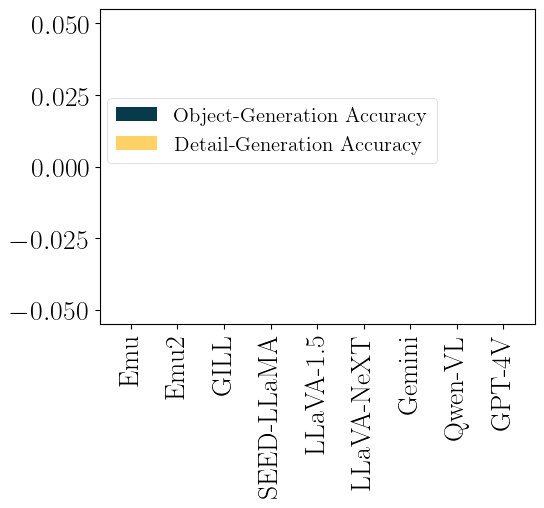

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


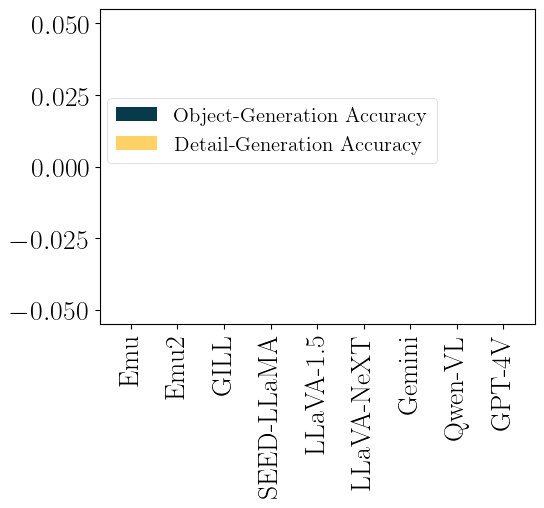

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


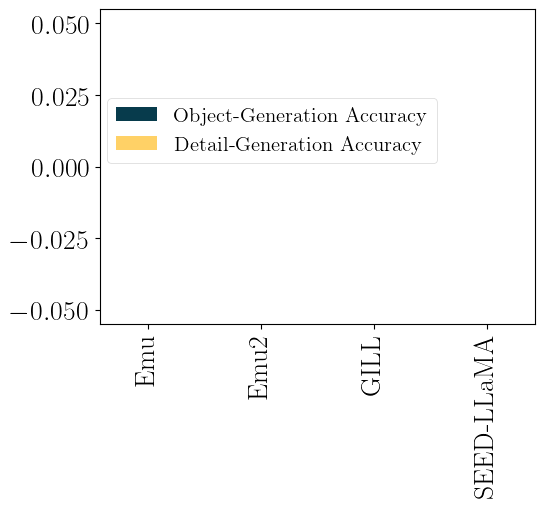

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


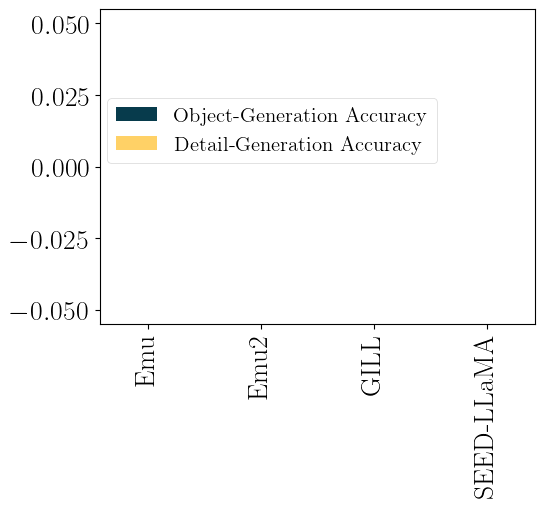

In [50]:
model_mode = 'text'
prompt_type = 'default'
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10
data_mode = 'default'

for model_mode in ['text', 'image']:
    for prompt_type in [0,1]:
        results = {}
        for metric in ['obj', 'detail']:
            results[metric] = {}
            for model in model_dict[model_mode]:
                results[metric][model] = {}
                for shot in [num_shot]:
                    results[metric][model][shot] = []
                    for task_id in task_dataframe:
                        results[metric][model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            prompt_type = prompt_type,
                            data_mode = data_mode,
                        ))
                        print(results[metric][model][shot][-1])
                    results[metric][model][shot] = np.mean(results[metric][model][shot])

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.98, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticklabels = []
        for i, model in enumerate(model_dict[model_mode]):
            ax.bar(barspace*i, results['obj'][model][num_shot], width = bar_width, color = colors[0], label = 'Object-Generation Accuracy')
            ax.bar(barspace*i + bar_width, results['detail'][model][num_shot], width = bar_width, color = colors[1], label = 'Detail-Generation Accuracy')
            xticklabels.append(model_dict[model_mode][model])
            
            if i == 0: ax.legend(bbox_to_anchor=(.8, .75), ncol=1, fontsize=15)
            
        ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
        ax.set_xticklabels(xticklabels, rotation = 90)
        fig.savefig(f'{root_dir}/figures/impact_obj_detail_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
        plt.show()

# Textual v.s. Visual

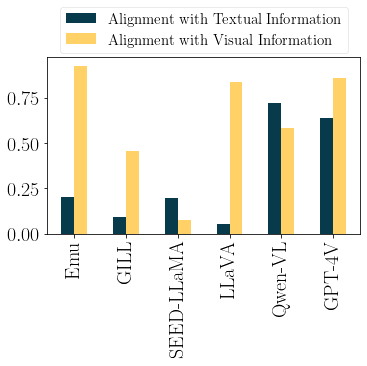

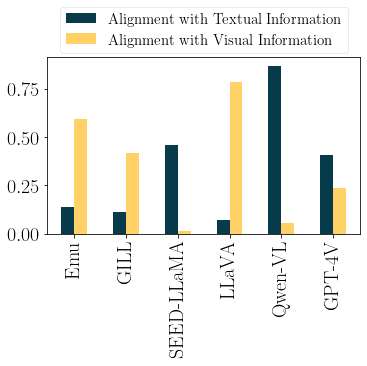

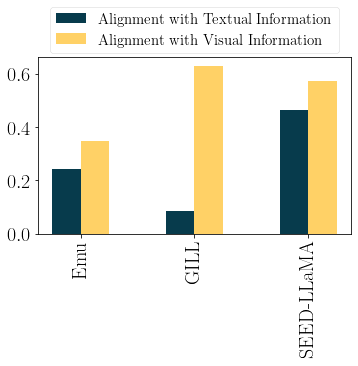

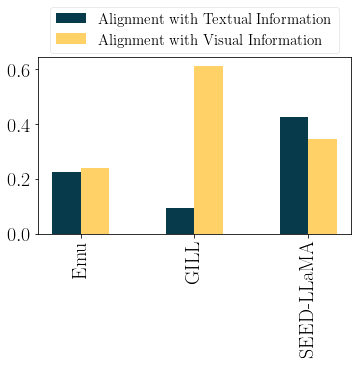

In [15]:
model_mode = 'text'
prompt_type = 0
width, height = 5,5
num_shot = 2
wspace = 1
barspace = 10

for model_mode in ['text', 'image']:
    for prompt_type in [0,1]:
        results = {}
        for metric in ['textual', 'visual']:
            results[metric] = {}
            for model in model_dict[model_mode]:
                results[metric][model] = {}
                for shot in num_shots:
                    results[metric][model][shot] = []
                    for task_id in task_dataframe:
                        results[metric][model][shot].append(get_acc(
                            model = model,
                            mode = model_mode,
                            shot = shot,
                            task_id = task_id,
                            metric = metric,
                            prompt_type = prompt_type,
                        ))
                    results[metric][model][shot] = np.mean(results[metric][model][shot])

        fig, ax = plt.subplots(nrows = 1, ncols = 1)
        fig.subplots_adjust(left=0.11, bottom=.35, right=0.98, top=.84, wspace=0, hspace = 0.3) #margin of the figure
        fig.set_size_inches(width, height) 

        xticklabels = []
        for i, model in enumerate(model_dict[model_mode]):
            ax.bar(barspace*i, results['textual'][model][num_shot], width = bar_width, color = colors[0], label = 'Alignment with Textual Information')
            ax.bar(barspace*i + bar_width, results['visual'][model][num_shot], width = bar_width, color = colors[1], label = 'Alignment with Visual Information')
            xticklabels.append(model_dict[model_mode][model])
            
            if i == 0: ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.33), ncol=1, fontsize=15)
            
        ax.set_xticks(barspace*np.arange(len(model_dict[model_mode]))+bar_width/2)
        ax.set_xticklabels(xticklabels, rotation = 90)
        fig.savefig(f'{root_dir}/figures/impact_textual_visual_shot_{num_shot}_{model_mode}_{prompt_type}.pdf')
        plt.show()